In [2]:
import numpy as np
import pandas as pd
import glob
from scipy.io import loadmat
from brainspace.gradient.gradient import GradientMaps
import func_plot as fp
import func_stats as fs
import nibabel as nib
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap
"./BD-SCZ/RSFC_HC_SCZ_BD_noGSR/sub*.mat"

'./BD-SCZ/RSFC_HC_SCZ_BD_noGSR/sub*.mat'

## Load FC

In [3]:
import re

files = np.sort(glob.glob("./BD-SCZ/RSFC_HC_SCZ_BD_noGSR/sub*.mat"))
fc = {}
for f in files:
    tmp = loadmat(f)['subj_final_corr_mat']
    # Extract participant ID using regex
    match = re.search(r"sub-(\d+)_", f)
    if match:
        pid = match.group(1)
        fc[pid] = tmp
        print(f"Loaded {f}, shape: {tmp.shape}, participant_id: {pid}")
    else:
        print(f"Could not extract participant ID from {f}")
print(f"Total files loaded: {len(fc)}")

Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10159_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10159
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10189_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10189
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10206_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10206
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10217_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10217
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10225_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10225
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10227_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10227
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10228_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10228
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10249_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10249
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\sub-10273_419ROIcorrMat.mat, shape: (419, 419), participant_id: 10273
Loaded ./BD-SCZ/RSFC_HC_SCZ_BD_noGSR\

## Load demographics

In [4]:
clinc_bd = pd.read_excel('./BD-SCZ/Demographics BD.xlsx')
clinc_scz = pd.read_excel('./BD-SCZ/Demographics SCZ.xlsx')
clinic = pd.concat([clinc_bd[['participant_id'] + list(clinc_bd.columns[5:])],
                    clinc_scz[['participant_id'] + list(clinc_scz.columns[5:])]],
                    axis=0,ignore_index=True)

In [5]:
# --- Robust demographics and FC matching ---
# Load main demographics CSV and ensure participant_id is string and cleaned
demo = pd.read_csv('./BD-SCZ/participants_HC_SCZ_BD.csv', header=1)
demo['participant_id'] = demo['participant_id'].astype(str).str.strip().str.upper()
print('Raw demo IDs:', demo['participant_id'].tolist())
# Extract numeric ID from demo to match FC keys (e.g., 'SUB-10159' -> '10159')
demo['participant_id_num'] = demo['participant_id'].str.extract(r'(\d+)$')[0]
print('Numeric demo IDs:', demo['participant_id_num'].tolist())
# FC keys are already numeric strings, print for debug
print('FC keys:', list(fc.keys()))
# Merge demo with FC keys to keep only subjects with FC data
id_df = pd.DataFrame({'participant_id_num': list(fc.keys())})
demo_merged = pd.merge(id_df, demo, on='participant_id_num', how='inner')
print('Merged demo shape:', demo_merged.shape)
print('Merged demo IDs:', demo_merged['participant_id_num'].tolist())
# Load clinical data and merge
clinc_bd = pd.read_excel('./BD-SCZ/Demographics BD.xlsx')
clinc_scz = pd.read_excel('./BD-SCZ/Demographics SCZ.xlsx')
clinic = pd.concat([clinc_bd[['participant_id'] + list(clinc_bd.columns[5:])],
                    clinc_scz[['participant_id'] + list(clinc_scz.columns[5:])]],
                    axis=0,ignore_index=True)
clinic['participant_id'] = clinic['participant_id'].astype(str).str.strip().str.upper()
clinic['participant_id_num'] = clinic['participant_id'].str.extract(r'(\d+)$')[0]
demo_merged = pd.merge(demo_merged, clinic, on='participant_id_num', how='left')
print('Final merged demo shape:', demo_merged.shape)
print('Final merged demo columns:', demo_merged.columns.tolist())
# Standardize diagnosis and gender columns
demo_merged['diagnosis'] = demo_merged['diagnosis'].replace({'CONTROL': 1, 'SCHZ': 2, 'BIPOLAR': 3})
demo_merged['diagnosis2'] = np.array(demo_merged['diagnosis'])
demo_merged.loc[demo_merged['diagnosis2'] == 3, 'diagnosis2'] = 2
demo_merged['gender'] = demo_merged['gender'].replace({'M': 1, 'F': 2})
print('Diagnosis values:', demo_merged['diagnosis'].unique())
print('Gender values:', demo_merged['gender'].unique())
# --- Group FC extraction ---
# Group FC: first 400 parcels
fc_CTR      = np.array([fc[i][:400, :400] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] == 1] if i in fc])
fc_SCZ      = np.array([fc[i][:400, :400] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] == 2] if i in fc])
fc_BD       = np.array([fc[i][:400, :400] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] == 3] if i in fc])
fc_mix      = np.array([fc[i][:400, :400] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] != 1] if i in fc])
print('fc_CTR shape (400 parcels):', fc_CTR.shape)
print('fc_SCZ shape (400 parcels):', fc_SCZ.shape)
print('fc_BD shape (400 parcels):', fc_BD.shape)
print('fc_mix shape (400 parcels):', fc_mix.shape)
# Group FC: full parcel matrices
fc_CTR_full = np.array([fc[i] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] == 1] if i in fc])
fc_SCZ_full = np.array([fc[i] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] == 2] if i in fc])
fc_BD_full  = np.array([fc[i] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] == 3] if i in fc])
fc_mix_full = np.array([fc[i] for i in demo_merged['participant_id_num'][demo_merged['diagnosis'] != 1] if i in fc])
print('fc_CTR_full shape (all parcels):', fc_CTR_full.shape)
print('fc_SCZ_full shape (all parcels):', fc_SCZ_full.shape)
print('fc_BD_full shape (all parcels):', fc_BD_full.shape)
print('fc_mix_full shape (all parcels):', fc_mix_full.shape)
# Use demo_merged for all downstream analysis
demo = demo_merged.copy()

Raw demo IDs: ['SUB-10159', 'SUB-10171', 'SUB-10189', 'SUB-10193', 'SUB-10206', 'SUB-10217', 'SUB-10225', 'SUB-10227', 'SUB-10228', 'SUB-10235', 'SUB-10249', 'SUB-10269', 'SUB-10271', 'SUB-10273', 'SUB-10274', 'SUB-10280', 'SUB-10290', 'SUB-10292', 'SUB-10299', 'SUB-10304', 'SUB-10316', 'SUB-10321', 'SUB-10325', 'SUB-10329', 'SUB-10339', 'SUB-10340', 'SUB-10345', 'SUB-10347', 'SUB-10356', 'SUB-10361', 'SUB-10365', 'SUB-10376', 'SUB-10377', 'SUB-10388', 'SUB-10428', 'SUB-10429', 'SUB-10438', 'SUB-10440', 'SUB-10448', 'SUB-10455', 'SUB-10460', 'SUB-10471', 'SUB-10478', 'SUB-10487', 'SUB-10492', 'SUB-10501', 'SUB-10506', 'SUB-10517', 'SUB-10523', 'SUB-10524', 'SUB-10525', 'SUB-10527', 'SUB-10530', 'SUB-10557', 'SUB-10565', 'SUB-10570', 'SUB-10575', 'SUB-10624', 'SUB-10629', 'SUB-10631', 'SUB-10638', 'SUB-10668', 'SUB-10672', 'SUB-10674', 'SUB-10678', 'SUB-10680', 'SUB-10686', 'SUB-10692', 'SUB-10696', 'SUB-10697', 'SUB-10704', 'SUB-10707', 'SUB-10708', 'SUB-10719', 'SUB-10724', 'SUB-10746

C:\Users\ferraras\AppData\Local\Temp\ipykernel_25248\188636190.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  demo_merged['diagnosis'] = demo_merged['diagnosis'].replace({'CONTROL': 1, 'SCHZ': 2, 'BIPOLAR': 3})
C:\Users\ferraras\AppData\Local\Temp\ipykernel_25248\188636190.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  demo_merged['gender'] = demo_merged['gender'].replace({'M': 1, 'F': 2})


fc_CTR shape (400 parcels): (110, 400, 400)
fc_SCZ shape (400 parcels): (37, 400, 400)
fc_BD shape (400 parcels): (40, 400, 400)
fc_mix shape (400 parcels): (77, 400, 400)
fc_CTR_full shape (all parcels): (110, 419, 419)
fc_SCZ_full shape (all parcels): (37, 419, 419)
fc_BD_full shape (all parcels): (40, 419, 419)
fc_mix_full shape (all parcels): (77, 419, 419)


## Load atlas & network

In [6]:
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

In [7]:
lut = pd.read_csv('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order_info.txt', header=None)
lut_color = np.array(lut.iloc[1::2])
lut_color = np.array([list(map(int, row[0].split())) for row in lut_color])
lut_color = lut_color[:,1:]
network_cmap = ListedColormap(lut_color/255)
lut_names = np.array(lut.iloc[::2])[:,0]
network=np.array([item[13:16] for item in lut_names])
network[network=='Vis'] = 1
network[network=='Som'] = 2
network[network=='Dor'] = 3
network[network=='Sal'] = 4
network[network=='Lim'] = 5
network[network=='Con'] = 6
network[network=='Def'] = 7
network = network.astype(int)
net_name = ['Vis', 'SMN', 'DAN', 'SN', 'Lim', 'FPN', 'DMN']
network

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,

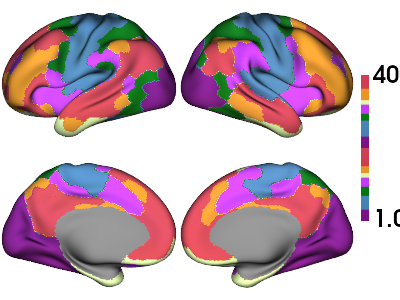

In [8]:
plot=atlas.copy()
plot[plot==0] = np.nan
fp.plot_surface(data=plot, size=(400,300), cmap=network_cmap, 
                color_range=(1,400), layout_style = 'grid',
                display=True, filename='./BD-SCZ/figures/atlas.png')

## Define eccentricity

In [9]:
def eccentricity(x,y,z):
    sum_xyz = pow(x,2) + pow(y,2) + pow(z,2)
    return pow(sum_xyz, 0.5)

## Group-level gradients & eccentricity    --    controls

In [10]:
# When computing group-level gradients, use only the first 400 parcels
gm = GradientMaps(approach='dm', kernel='normalized_angle', random_state=0)
gm.fit(fc_CTR.mean(0), sparsity=0.9)  # fc_CTR is already [:400, :400]

GradientMaps(random_state=0)

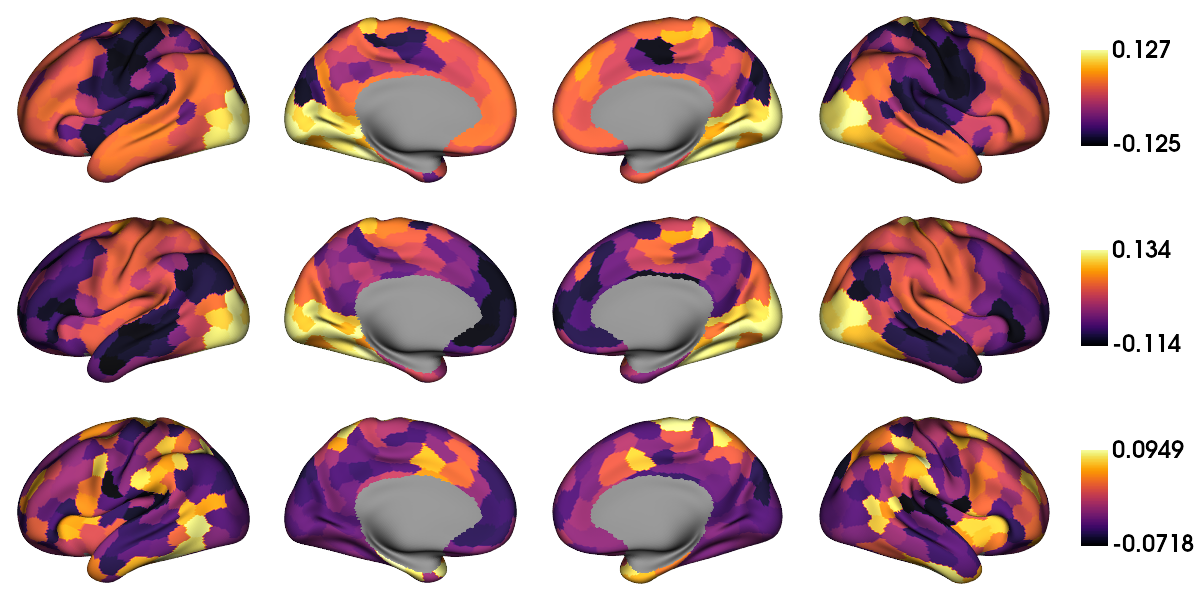

In [12]:
tmp=[gm.gradients_[:,0],gm.gradients_[:,1],gm.gradients_[:,2]]
np.savetxt('./gradients_group_level.csv',np.array(tmp).T)
plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='inferno', #color_range=(-0.14,0.14),
                display=True, filename='./new_figures/CTR_G1-3.png') 

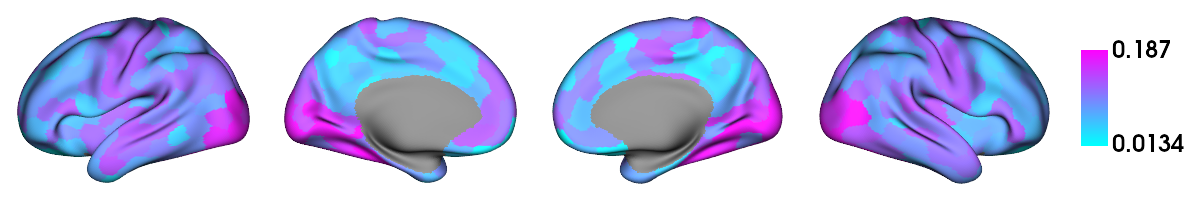

In [49]:
tmp = [eccentricity(gm.gradients_[:,0],gm.gradients_[:,1],gm.gradients_[:,2])]
np.savetxt('./eccentricity_group_level.csv',np.array(tmp).T)
plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='cool', #color_range=(-0.14,0.14),
                display=True, filename='./figures/CTR_eccentricity.png') 

In [13]:
# Check shapes for group and reference gradients
print('fc_CTR shape:', fc_CTR.shape)
print('fc_CTR_full shape:', fc_CTR_full.shape)
if hasattr(gm, 'gradients_') and gm.gradients_ is not None:
    print('gm.gradients_ shape:', gm.gradients_.shape)
else:
    print('gm.gradients_ not computed yet')

fc_CTR shape: (110, 400, 400)
fc_CTR_full shape: (110, 419, 419)
gm.gradients_ shape: (400, 10)


## Individual aligned and unaligned gradients

In [18]:
grad={}
eccen_unaligned={}
eccen_aligned={}
eccen_7={}
eccen_7u={}
for i in fc.keys():
    fc_sub = fc[i][:400, :400]
    print(f"Subject {i} fc_sub shape:", fc_sub.shape)
    print("Reference gm.gradients_ shape:", gm.gradients_.shape)
    tmp = GradientMaps(approach='pca', kernel='normalized_angle', alignment='procrustes', random_state=0)
    grad[i] = tmp.fit(fc_sub, sparsity=0.9, reference=gm.gradients_)
    eccen_aligned[i] = eccentricity(tmp.aligned_[:,0], tmp.aligned_[:,1], tmp.aligned_[:,2])
    eccen_unaligned[i] = eccentricity(tmp.gradients_[:,0], tmp.gradients_[:,1], tmp.gradients_[:,2])
    tmp7 = np.zeros(7)
    tmp7u = np.zeros(7)
    for j in range(7):
        tmp7[j] = eccen_aligned[i][network==j+1].mean()
        tmp7u[j] = eccen_unaligned[i][network==j+1].mean()
    eccen_7[i] = tmp7.copy()
    eccen_7u[i] = tmp7u.copy()

Subject 10159 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10189 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10206 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10217 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10225 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10227 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10228 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10249 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10273 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10274 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10280 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10290 fc_sub shape: (400, 400)
Reference gm.gradients_ shape: (400, 10)
Subject 10292 fc_sub shape: (400, 400)
R

In [19]:
tmp_df = pd.DataFrame.from_dict(eccen_aligned, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id_num').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id_num')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df.to_csv('./eccentricity_aligned.csv', index=False)
tmp_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  node_391  node_392  node_393  node_394  node_395  \
0       NaN     NaN  ...  1.050748  0.979967  1.029193  1.088396  0.473769   
1       NaN     NaN  ...  0.398876  0.204322  0.428275  0.303628  0.244905   
2       NaN     NaN  ...  0.800805  0.688456  0.915019  0.630230  0.537575   
3       NaN     NaN  ...  0.647360  0.393221  0.307519  1.158733  0.696789   
4       NaN     NaN  ...  0.464948  0.765925  0.208833  0.504321  0.769739   
..      ...     ...  ...       ...       ...       ...       ...       ...   
182     1.0     1.0  ...  0.457562  0.813778  0.431881  0.719921  0.678427   
183     1.0     1.0  ...  0.669280  0.774511  0.517442  0.591937  0.432947   
184     1.0     1.0  ...  0.660133  0.863572  0.391405  0.842363  0.863215   
185     1.0     1.0  ...  0.392465  0.494105  0.520347  0.920234  0.542743   
186     1.0     1.0  ...  0.397319  0.181673  0.112452  0.359036  0.358778   

     node_396  node_397  node_398  node_399  node_400  
0    0.395917  0.147069  0.203967  0.590947  0.394315  
1    0.430106  0.512342  0.393541  0.429298  0.477103  
2    0.489435  0.729209  1.073083  0.673867  0.526454  
3    0.212916  0.688527  0.790533  0.298915  1.047033  
4    0.575280  0.650111  0.866534  0.628912  0.634569  
..        ...       ...       ...       ...       ...  
182  0.933474  0.318604  0.295193  0.398735  0.719541  
183  0.382549  0.579649  0.669757  0.798237  0.522621  
184  0.441559  0.150216  0.380470  0.948547  0.437352  
185  1.339342  0.532764  0.761920  1.160540  0.539415  
186  0.608955  0.216232  0.670083  0.247471  0.310905  

[187 rows x 428 columns]

In [20]:
net_df = pd.DataFrame.from_dict(eccen_7, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id_num').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id_num')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df.to_csv('./eccentricity_net_aligned.csv', index=False)
net_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  hamilton_21  Risperidone equivalent dose  \
0       NaN     NaN  ...          NaN                          NaN   
1       NaN     NaN  ...          NaN                          NaN   
2       NaN     NaN  ...          NaN                          NaN   
3       NaN     NaN  ...          NaN                          NaN   
4       NaN     NaN  ...          NaN                          NaN   
..      ...     ...  ...          ...                          ...   
182     1.0     1.0  ...         27.0                         0.00   
183     1.0     1.0  ...         33.0                         1.67   
184     1.0     1.0  ...         26.0                        15.00   
185     1.0     1.0  ...          4.0                         0.00   
186     1.0     1.0  ...         18.0                         0.00   

     diagnosis2     net_1     net_2     net_3     net_4     net_5     net_6  \
0             1  1.241908  0.950830  0.894165  0.777268  0.528722  0.772141   
1             1  0.913744  0.651950  0.558030  0.531831  0.548856  0.568554   
2             1  1.141204  0.971951  1.043806  0.983419  0.706724  0.803062   
3             1  1.313771  1.148156  0.968381  0.879410  0.688935  0.908418   
4             1  0.989360  1.010102  0.875164  0.743529  0.741831  0.766840   
..          ...       ...       ...       ...       ...       ...       ...   
182           2  1.143906  0.882582  0.891963  0.819068  0.661359  0.787506   
183           2  0.721379  0.608082  0.898337  0.755521  0.574982  0.737278   
184           2  0.851908  0.785750  0.655591  0.686151  0.756005  0.668664   
185           2  1.173310  1.271799  0.956959  0.849971  0.780097  0.920473   
186           2  0.542570  0.583497  0.583523  0.603210  0.671973  0.682654   

        net_7  
0    0.815948  
1    0.565438  
2    1.085706  
3    0.833987  
4    0.768356  
..        ...  
182  0.965828  
183  0.799777  
184  0.628054  
185  0.878276  
186  0.595780  

[187 rows x 35 columns]

## Stats CTR vs BD+SCZ p < 0.01

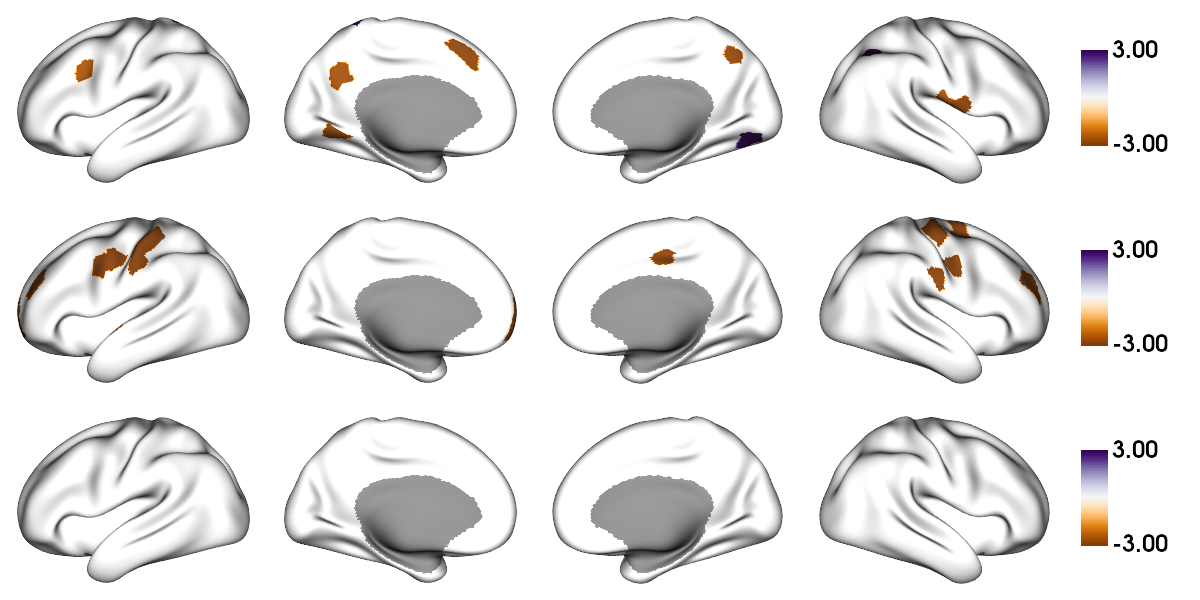

In [21]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/eccentricity_aligned_2groups_t.png')

In [22]:
# Debug: Check shapes for individual and reference gradients
for i in fc.keys():
    fc_sub = fc[i][:400, :400]
    print(f"Subject {i} fc_sub shape:", fc_sub.shape)
print("Reference gm.gradients_ shape:", gm.gradients_.shape)

Subject 10159 fc_sub shape: (400, 400)
Subject 10189 fc_sub shape: (400, 400)
Subject 10206 fc_sub shape: (400, 400)
Subject 10217 fc_sub shape: (400, 400)
Subject 10225 fc_sub shape: (400, 400)
Subject 10227 fc_sub shape: (400, 400)
Subject 10228 fc_sub shape: (400, 400)
Subject 10249 fc_sub shape: (400, 400)
Subject 10273 fc_sub shape: (400, 400)
Subject 10274 fc_sub shape: (400, 400)
Subject 10280 fc_sub shape: (400, 400)
Subject 10290 fc_sub shape: (400, 400)
Subject 10292 fc_sub shape: (400, 400)
Subject 10304 fc_sub shape: (400, 400)
Subject 10321 fc_sub shape: (400, 400)
Subject 10325 fc_sub shape: (400, 400)
Subject 10329 fc_sub shape: (400, 400)
Subject 10339 fc_sub shape: (400, 400)
Subject 10340 fc_sub shape: (400, 400)
Subject 10345 fc_sub shape: (400, 400)
Subject 10347 fc_sub shape: (400, 400)
Subject 10356 fc_sub shape: (400, 400)
Subject 10365 fc_sub shape: (400, 400)
Subject 10376 fc_sub shape: (400, 400)
Subject 10377 fc_sub shape: (400, 400)
Subject 10388 fc_sub shap

In [23]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD+SCZ")

In [24]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("hamilton_21")

In [25]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS Positive Symptoms'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS Positive Symptoms")

In [26]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS disorganization'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS disorganization")

In [27]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("Amotivation")

In [28]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("DimEx")

## Stats CTR vs BD vs SCZ p < 0.01

### SCZ

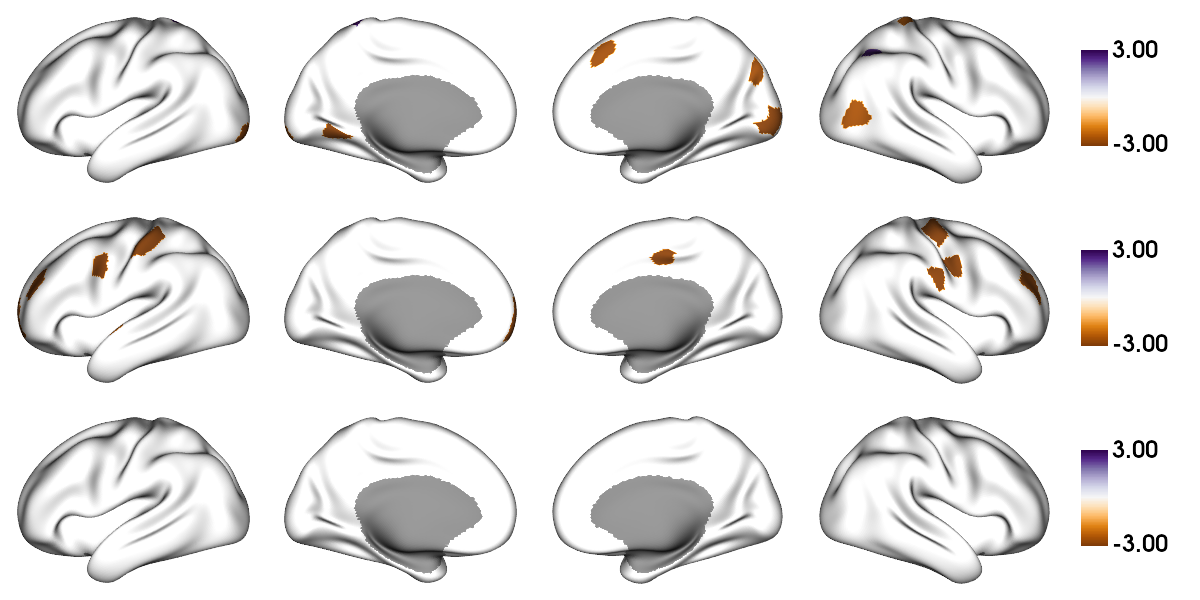

In [32]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/eccentricity_aligned_3groups_SCZ_t.png')

In [30]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption("CTR vs SCZ")

### BD

In [31]:
model[0].tvalues['C(diagnosis)[T.3]']

np.float64(0.07247653678351784)

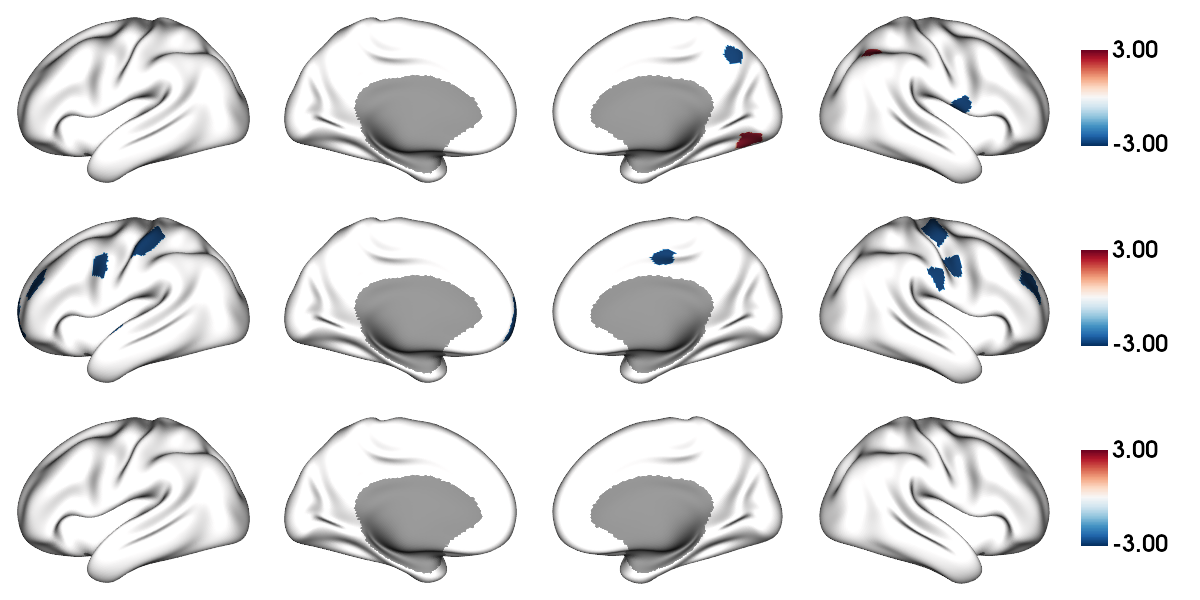

In [33]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()
  
tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./new_figures/eccentricity_aligned_3groups_BD_t.png')

In [34]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs SCZ")

## Multivariate - Hotelling's T

In [35]:
g_n=0 #g1
g_name =str(g_n+1)
g = {}
g_net = {}
for i in grad.keys():
    g[i] = grad.get(i).aligned_[:,g_n] # change number here
    g_net[i] = np.zeros(7)
    for j in range(7):
        g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id_num').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id_num')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  node_391  node_392  node_393  node_394  node_395  \
0       NaN     NaN  ...  0.293058  0.333525  0.276344  0.285946  0.272746   
1       NaN     NaN  ...  0.003983  0.102160 -0.248962 -0.114747 -0.150928   
2       NaN     NaN  ...  0.196834  0.197836  0.211513  0.375254  0.201084   
3       NaN     NaN  ... -0.273579  0.183064 -0.235673 -0.611974 -0.415724   
4       NaN     NaN  ...  0.325805  0.409143 -0.054301 -0.192678  0.359536   
..      ...     ...  ...       ...       ...       ...       ...       ...   
182     1.0     1.0  ... -0.188262  0.137830 -0.316135 -0.017967  0.058176   
183     1.0     1.0  ...  0.162972  0.355368  0.076695 -0.007657 -0.098960   
184     1.0     1.0  ...  0.453722  0.344447  0.190940  0.198609  0.654311   
185     1.0     1.0  ... -0.128273  0.287066  0.015195 -0.467368  0.224982   
186     1.0     1.0  ... -0.311220  0.037522 -0.031409  0.069287 -0.248159   

     node_396  node_397  node_398  node_399  node_400  
0    0.377533  0.136228 -0.020011  0.321678  0.357778  
1    0.393078  0.364770  0.268570  0.387141 -0.176943  
2    0.188103  0.442987  0.599450  0.403441  0.237487  
3    0.124945  0.405987 -0.521967  0.075728  0.284097  
4    0.320412 -0.430109 -0.435302  0.129236 -0.188657  
..        ...       ...       ...       ...       ...  
182  0.299849 -0.263776  0.044686 -0.277886 -0.441036  
183 -0.151965 -0.311674  0.572900 -0.534675 -0.480030  
184 -0.399693 -0.145513 -0.136740  0.073763  0.256579  
185  0.536274  0.236163 -0.263711  0.497652  0.186272  
186 -0.418907 -0.150904 -0.356467  0.212429 -0.157704  

[187 rows x 428 columns]

In [36]:
gradients_individual = [None] * 3
gradients_individual_net = [None] * 3
for g_n in range(3):
    g_name =str(g_n+1)
    g = {}
    g_net = {}
    for i in grad.keys():
        g[i] = grad.get(i).aligned_[:,g_n] # change number here
        g_net[i] = np.zeros(7)
        for j in range(7):
            g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
    gradients_individual[g_n] = np.array(pd.DataFrame.from_dict(g, orient='index'))
    gradients_individual_net[g_n] = np.array(pd.DataFrame.from_dict(g_net, orient='index'))

In [37]:
from statsmodels.multivariate.manova import MANOVA

In [38]:
f_mv = np.zeros(400)
p_mv = np.zeros(400)
for i in range(400):
    tmp = MANOVA(endog = np.array([gradients_individual[0][:,i],gradients_individual[1][:,i],gradients_individual[2][:,i]]).T,
                 exog = add_constant(tmp_df[['diagnosis2','age','gender']])).mv_test()
    f_mv[i] = tmp.results['x1']['stat']['F Value']['Hotelling-Lawley trace']
    p_mv[i] = tmp.results['x1']['stat']['Pr > F']['Hotelling-Lawley trace']

In [39]:
fs.fdr(p_mv).min(), f_mv.min(), f_mv.max()

(np.float64(0.07213794054807587),
 np.float64(0.025247712043700344),
 np.float64(6.981550390486958))

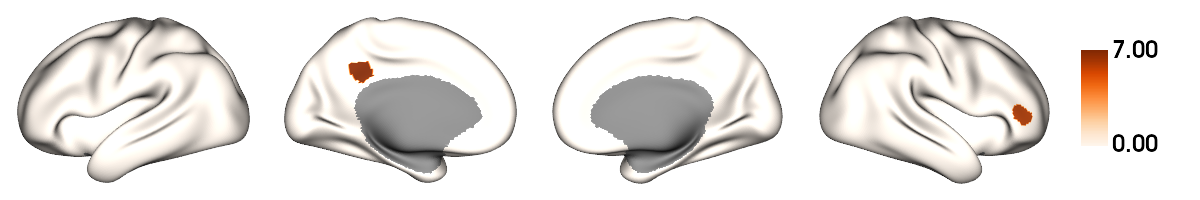

In [41]:
plot = atlas.copy()
f_mv_copy = f_mv.copy()
f_mv_copy[p_mv > 0.001] = 0 # No sig. after FDR so here using p<0.001
for j in range(400):
    plot[atlas==j+1] = f_mv_copy[j]
plot[atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200), cmap='Oranges', color_range=(0,7),
                display=True, filename='./new_figures/aligned_2groups_t_hotelling.png')

In [42]:
f_mv_net = np.zeros(7)
p_mv_net = np.zeros(7)
for i in range(7):
    tmp = MANOVA(endog = np.array([gradients_individual_net[0][:,i],
                                   gradients_individual_net[1][:,i],
                                   gradients_individual_net[2][:,i]]).T,
                 exog = add_constant(tmp_df[['diagnosis2','age','gender']])).mv_test()
    f_mv_net[i] = tmp.results['x1']['stat']['F Value']['Hotelling-Lawley trace']
    p_mv_net[i] = tmp.results['x1']['stat']['Pr > F']['Hotelling-Lawley trace']

In [43]:
sts = pd.DataFrame()
sts['Network'] = net_name
sts['F'] = f_mv_net
sts['pvalue'] = p_mv_net
sts['p_fdr'] = fs.fdr(p_mv_net)
sts.style.set_caption("Multivariate MANOVA for 7 networks")

## G1: p<0.01

In [44]:
g_n=0 #g1
g_name =str(g_n+1)
g = {}
g_net = {}
for i in grad.keys():
    g[i] = grad.get(i).aligned_[:,g_n] # change number here
    g_net[i] = np.zeros(7)
    for j in range(7):
        g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id_num').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id_num')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df.to_csv('./g1_aligned.csv', index=False)
tmp_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  node_391  node_392  node_393  node_394  node_395  \
0       NaN     NaN  ...  0.293058  0.333525  0.276344  0.285946  0.272746   
1       NaN     NaN  ...  0.003983  0.102160 -0.248962 -0.114747 -0.150928   
2       NaN     NaN  ...  0.196834  0.197836  0.211513  0.375254  0.201084   
3       NaN     NaN  ... -0.273579  0.183064 -0.235673 -0.611974 -0.415724   
4       NaN     NaN  ...  0.325805  0.409143 -0.054301 -0.192678  0.359536   
..      ...     ...  ...       ...       ...       ...       ...       ...   
182     1.0     1.0  ... -0.188262  0.137830 -0.316135 -0.017967  0.058176   
183     1.0     1.0  ...  0.162972  0.355368  0.076695 -0.007657 -0.098960   
184     1.0     1.0  ...  0.453722  0.344447  0.190940  0.198609  0.654311   
185     1.0     1.0  ... -0.128273  0.287066  0.015195 -0.467368  0.224982   
186     1.0     1.0  ... -0.311220  0.037522 -0.031409  0.069287 -0.248159   

     node_396  node_397  node_398  node_399  node_400  
0    0.377533  0.136228 -0.020011  0.321678  0.357778  
1    0.393078  0.364770  0.268570  0.387141 -0.176943  
2    0.188103  0.442987  0.599450  0.403441  0.237487  
3    0.124945  0.405987 -0.521967  0.075728  0.284097  
4    0.320412 -0.430109 -0.435302  0.129236 -0.188657  
..        ...       ...       ...       ...       ...  
182  0.299849 -0.263776  0.044686 -0.277886 -0.441036  
183 -0.151965 -0.311674  0.572900 -0.534675 -0.480030  
184 -0.399693 -0.145513 -0.136740  0.073763  0.256579  
185  0.536274  0.236163 -0.263711  0.497652  0.186272  
186 -0.418907 -0.150904 -0.356467  0.212429 -0.157704  

[187 rows x 428 columns]

In [45]:
net_df = pd.DataFrame.from_dict(g_net, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id_num').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id_num')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df.to_csv('./g1_net_aligned.csv', index=False)
net_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  hamilton_21  Risperidone equivalent dose  \
0       NaN     NaN  ...          NaN                          NaN   
1       NaN     NaN  ...          NaN                          NaN   
2       NaN     NaN  ...          NaN                          NaN   
3       NaN     NaN  ...          NaN                          NaN   
4       NaN     NaN  ...          NaN                          NaN   
..      ...     ...  ...          ...                          ...   
182     1.0     1.0  ...         27.0                         0.00   
183     1.0     1.0  ...         33.0                         1.67   
184     1.0     1.0  ...         26.0                        15.00   
185     1.0     1.0  ...          4.0                         0.00   
186     1.0     1.0  ...         18.0                         0.00   

     diagnosis2     net_1     net_2     net_3     net_4     net_5     net_6  \
0             1  0.349822 -0.296807 -0.357865 -0.423958  0.131600  0.156064   
1             1  0.383961 -0.251123 -0.187744 -0.170120 -0.032199  0.122704   
2             1  0.408426 -0.216941 -0.566567 -0.469539  0.007143  0.158552   
3             1  0.394744 -0.414336 -0.354986 -0.137158  0.125859  0.246476   
4             1  0.135172 -0.544507 -0.344108 -0.063483  0.245540  0.320951   
..          ...       ...       ...       ...       ...       ...       ...   
182           2  0.527285 -0.358270 -0.351240 -0.368271 -0.110875  0.120503   
183           2  0.285260 -0.242391 -0.600977 -0.367906 -0.023695  0.338010   
184           2  0.256632 -0.289976 -0.142367 -0.119838  0.146386  0.090599   
185           2  0.147637 -0.663610 -0.264519 -0.190711  0.366878  0.398343   
186           2 -0.022273 -0.182726 -0.119677 -0.142771  0.272722  0.262082   

        net_7  
0    0.289735  
1    0.076959  
2    0.346049  
3    0.159464  
4    0.323305  
..        ...  
182  0.280273  
183  0.321311  
184  0.113601  
185  0.362316  
186  0.076097  

[187 rows x 35 columns]

In [46]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs BD+SCZ')

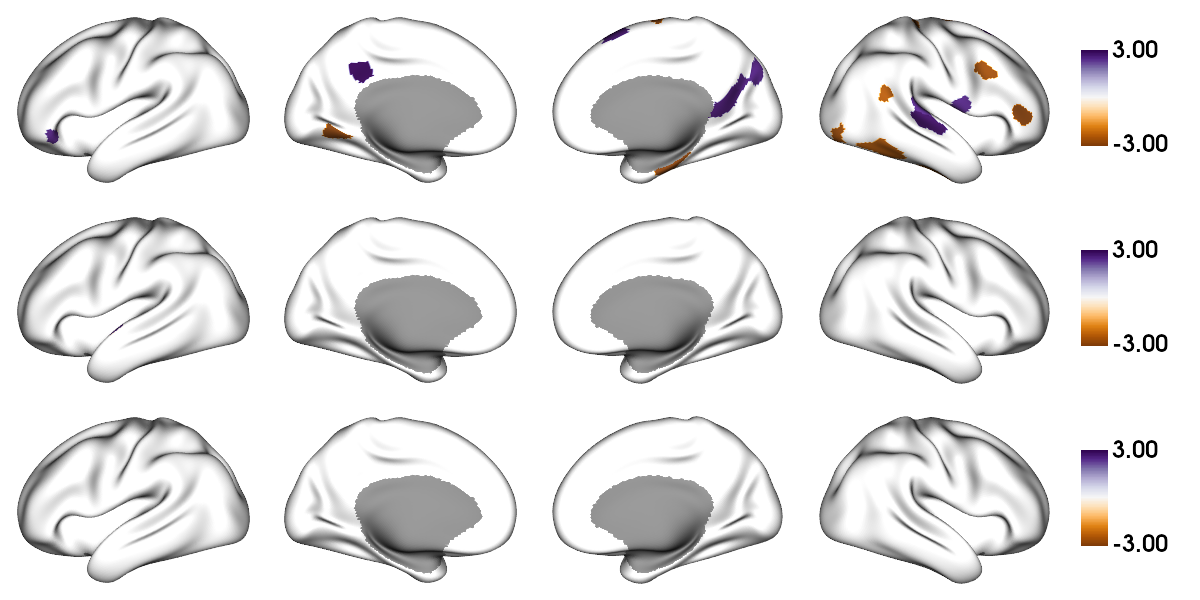

In [47]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]) > 0.017] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_2groups_t.png')

In [48]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs BD+SCZ')

In [49]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("hamilton_21")

In [50]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("hamilton_21")

In [51]:
## Compute subcortical weighted manifold (nodal degree)
# This section computes the weighted manifold for each subcortical region using:
# M_i = (1/N) * sum_j C_{i,j} * G_j
# where C_{i,j} is the connectivity between subcortical region i and cortical parcel j,
# G_j is the gradient value for cortical parcel j, and N is the number of cortical parcels.

import numpy as np
import pandas as pd

# Use the full matrices created earlier
# fc_CTR_full, fc_SCZ_full, fc_BD_full, fc_mix_full
# Each is shape (n_subjects, n_parcels, n_parcels)
# We'll use the last 14 rows for subcortex and first 400 columns for cortex

def compute_subcortical_weighted_manifold(fc_group_full, gradients):
    # fc_group_full: shape (n_subjects, n_parcels, n_parcels)
    # gradients: shape (n_parcels,)
    results = []
    for subj_fc in fc_group_full:
        # Subcortex: last 14 rows, Cortex: first 400 columns
        Ci_j = subj_fc[-14:, :400]  # shape (14, 400)
        Gj = gradients[:400]        # shape (400,)
        Mi = (Ci_j * Gj[np.newaxis, :]).mean(axis=1)  # mean over cortex parcels
        results.append(Mi)
    return np.array(results)

# Example usage for controls:
# gradients_group = ... # shape (414,) or (400,) depending on your gradient file
# If you have a file, load it here:
# gradients_group = np.loadtxt('./BD-SCZ/g1_aligned.csv')

# For demonstration, check if gradients_group is loaded, else skip
try:
    gradients_group = np.loadtxt('./BD-SCZ/g1_aligned.csv')
    if gradients_group.shape[0] == 414:
        Mi_CTR = compute_subcortical_weighted_manifold(fc_CTR_full, gradients_group)
        print('Subcortical nodal degree (controls, per subject):')
        print(Mi_CTR)
    else:
        print('Gradient file does not have 414 parcels.')
except Exception as e:
    print('Could not load gradients_group:', e)


Could not load gradients_group: could not convert string 'participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch, to float64 at row 0, column 1.


In [52]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("Amotivation")

In [53]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("DimEx")

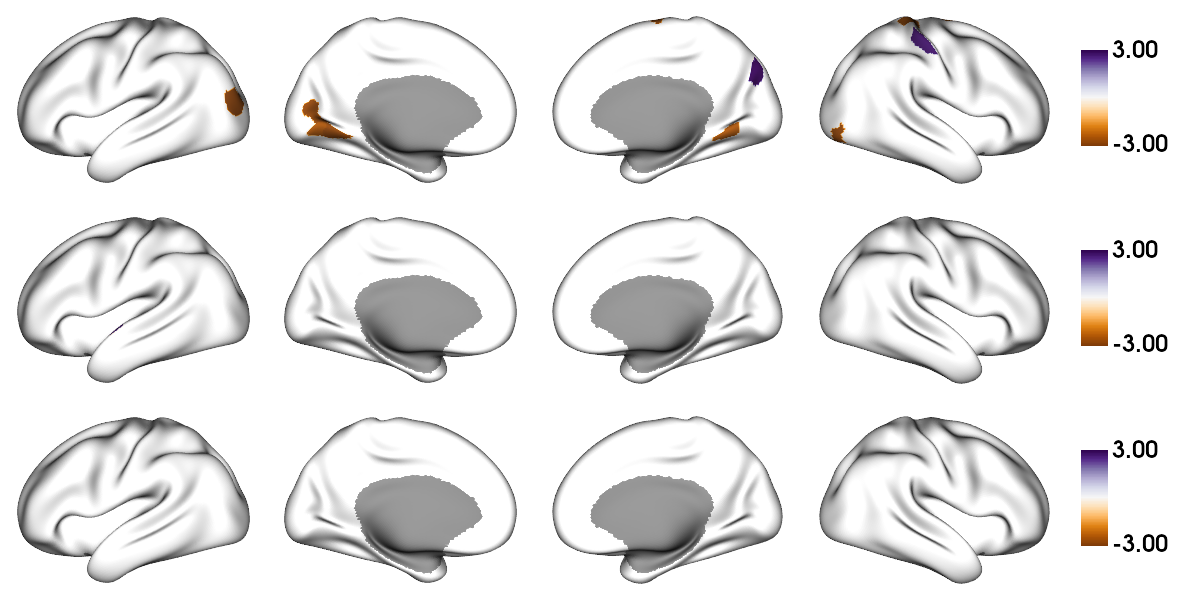

In [54]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_3groups_SCZ_t.png')

In [55]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global blunted affect'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global blunted affect")

In [56]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global alogia'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global alogia")

In [57]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global anhedonia'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global anhedonia")

In [58]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global avolition'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global avolition")

In [59]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption("CTR vs SCZ")

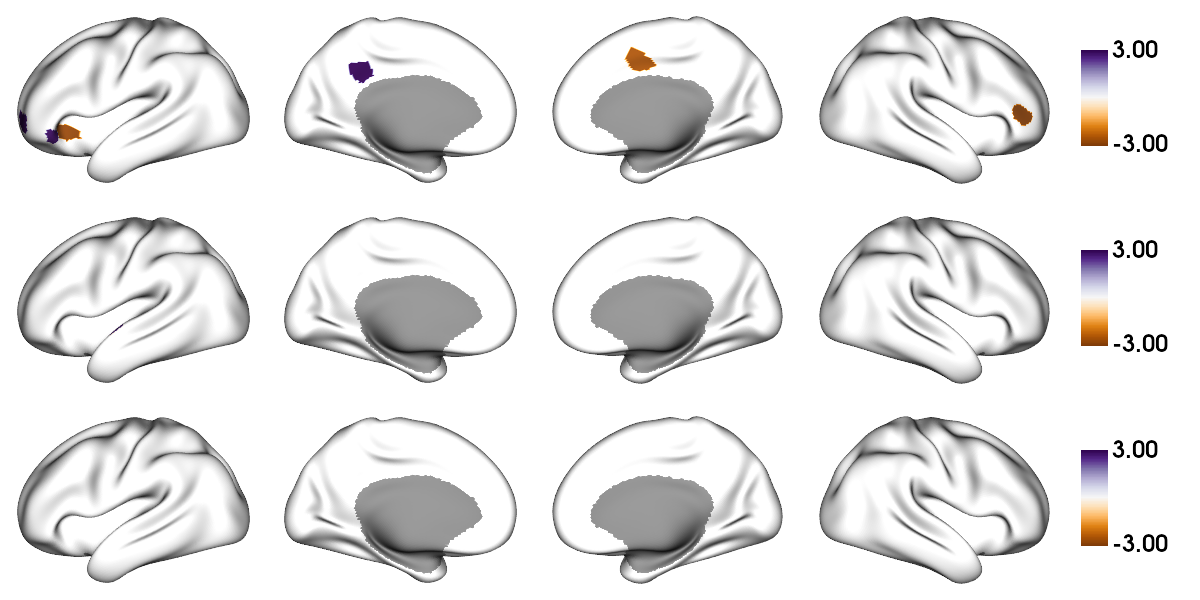

In [60]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_3groups_BD_t.png')

In [61]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD")

## G2: p<0.01

In [62]:
g_n=1 #g2
g_name =str(g_n+1)
g = {}
g_net = {}
for i in grad.keys():
    g[i] = grad.get(i).aligned_[:,g_n] # change number here
    g_net[i] = np.zeros(7)
    for j in range(7):
        g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id_num').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id_num')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df.to_csv('./g2_aligned.csv', index=False)
tmp_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  node_391  node_392  node_393  node_394  node_395  \
0       NaN     NaN  ... -0.936096 -0.863041 -0.920467 -0.979188 -0.361972   
1       NaN     NaN  ... -0.025126 -0.037237 -0.076984 -0.226553  0.163979   
2       NaN     NaN  ... -0.647688 -0.464069 -0.777675  0.265660 -0.242728   
3       NaN     NaN  ...  0.051996 -0.175292 -0.081231  0.580120  0.321793   
4       NaN     NaN  ... -0.004751 -0.563323  0.103388  0.053090 -0.668505   
..      ...     ...  ...       ...       ...       ...       ...       ...   
182     1.0     1.0  ... -0.367798 -0.721985 -0.293984 -0.579799 -0.572003   
183     1.0     1.0  ... -0.301434 -0.369643 -0.384697  0.010057  0.028474   
184     1.0     1.0  ... -0.192447 -0.243729 -0.063009 -0.200039  0.088712   
185     1.0     1.0  ...  0.108339 -0.203515  0.393274  0.764885 -0.435147   
186     1.0     1.0  ...  0.168686 -0.032903 -0.106282  0.019248 -0.214287   

     node_396  node_397  node_398  node_399  node_400  
0    0.067148  0.040192 -0.181577 -0.481767  0.130591  
1    0.094363  0.280451  0.286138 -0.023871  0.047079  
2   -0.213940  0.577597  0.810048  0.476555 -0.087955  
3    0.170858  0.528641  0.377876 -0.153536 -0.920078  
4   -0.441811  0.064883  0.587522 -0.233699 -0.026040  
..        ...       ...       ...       ...       ...  
182 -0.816562  0.176600  0.212501 -0.120668  0.046494  
183 -0.012758  0.111404  0.270186  0.315200  0.105591  
184 -0.138677  0.011474 -0.261022 -0.539417 -0.121505  
185 -1.152573 -0.438383  0.712533 -1.029684  0.017247  
186  0.339323  0.154398  0.550993  0.095032  0.211426  

[187 rows x 428 columns]

In [63]:
net_df = pd.DataFrame.from_dict(g_net, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id_num').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id_num')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df.to_csv('./g2_net_aligned.csv', index=False)
net_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  hamilton_21  Risperidone equivalent dose  \
0       NaN     NaN  ...          NaN                          NaN   
1       NaN     NaN  ...          NaN                          NaN   
2       NaN     NaN  ...          NaN                          NaN   
3       NaN     NaN  ...          NaN                          NaN   
4       NaN     NaN  ...          NaN                          NaN   
..      ...     ...  ...          ...                          ...   
182     1.0     1.0  ...         27.0                         0.00   
183     1.0     1.0  ...         33.0                         1.67   
184     1.0     1.0  ...         26.0                        15.00   
185     1.0     1.0  ...          4.0                         0.00   
186     1.0     1.0  ...         18.0                         0.00   

     diagnosis2     net_1     net_2     net_3     net_4     net_5     net_6  \
0             1  0.743055  0.298604  0.294028  0.129382 -0.266127 -0.512907   
1             1  0.649611  0.200513  0.079247 -0.130195 -0.282082 -0.297030   
2             1  0.840436  0.484907  0.328210 -0.138816 -0.314695 -0.478211   
3             1  0.905052  0.550849  0.180736 -0.304132 -0.330163 -0.682419   
4             1  0.532914  0.463434  0.224919 -0.108808 -0.275919 -0.449844   
..          ...       ...       ...       ...       ...       ...       ...   
182           2  0.790451  0.296169  0.224689  0.014351 -0.083514 -0.385286   
183           2  0.161527  0.209524  0.273266  0.160798  0.114761 -0.252012   
184           2  0.314215  0.146856  0.070247  0.020794 -0.189611 -0.154736   
185           2  0.589679  0.550186  0.359150  0.002905 -0.423815 -0.626198   
186           2  0.376693  0.260218  0.280897  0.031967 -0.367793 -0.384418   

        net_7  
0   -0.597084  
1   -0.327607  
2   -0.704711  
3   -0.522781  
4   -0.470975  
..        ...  
182 -0.657434  
183 -0.395532  
184 -0.238545  
185 -0.564952  
186 -0.306444  

[187 rows x 35 columns]

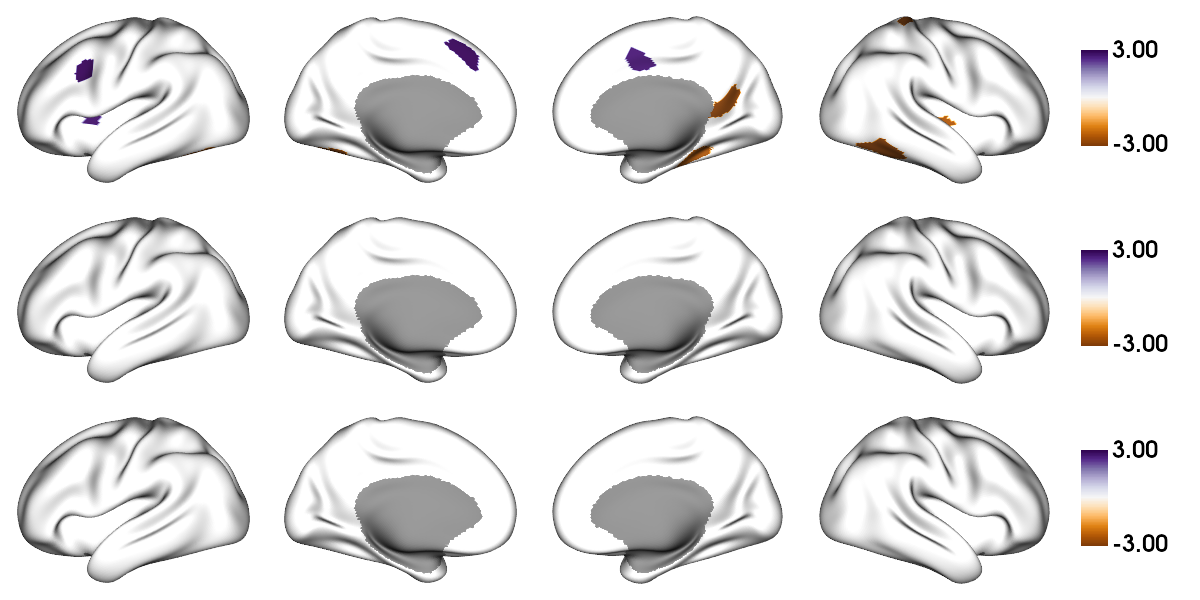

In [64]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]) > 0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_2groups_t.png')

In [65]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs BD+SCZ')

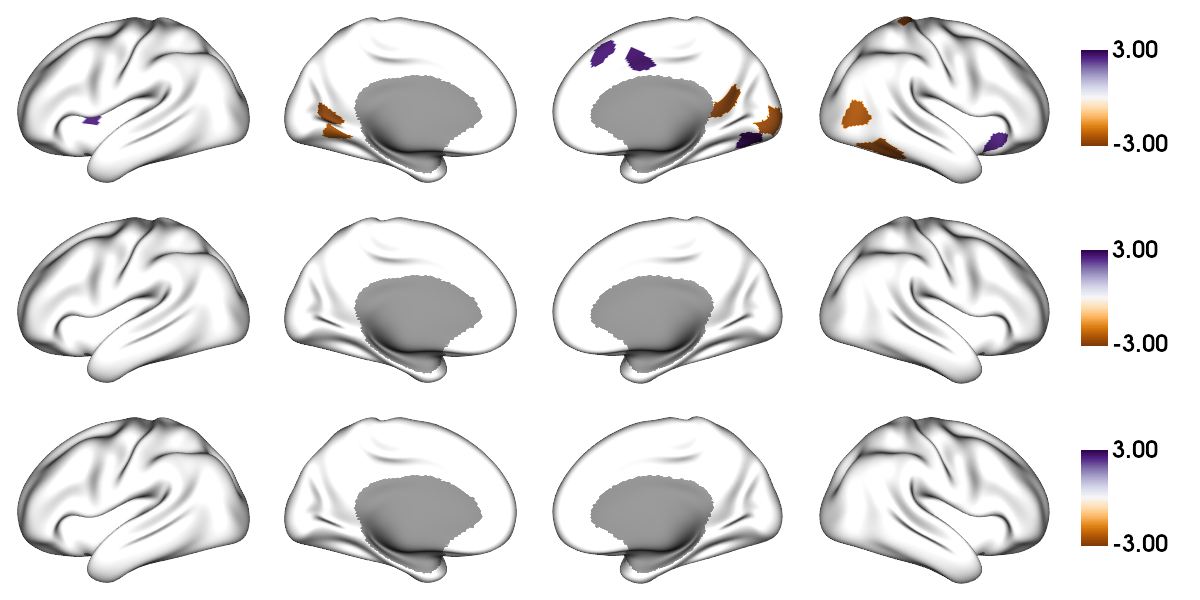

In [66]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_3groups_SCZ_t.png')

In [67]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs SCZ')

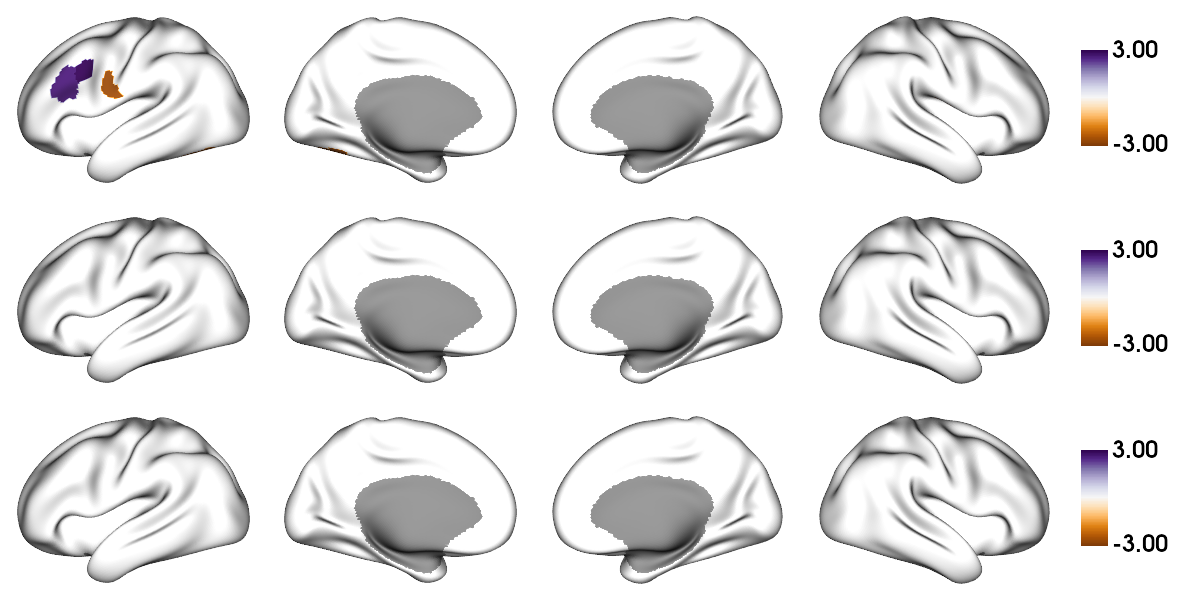

In [68]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_3groups_BD_t.png')

In [69]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD")

In [70]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("hamilton_21")

In [71]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS Positive Symptoms'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("SAPS Positive Symptoms")

In [72]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS disorganization'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("SAPS disorganization")

In [73]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("Amotivation")

In [74]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("DimEx")

In [75]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global blunted affect'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global blunted affect")

In [76]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global alogia'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global alogia")

In [77]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global anhedonia'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global anhedonia")

In [78]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global avolition'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global avolition")

## G3: p<0.01

In [79]:
g_n=2 #g2
g_name =str(g_n+1)
g = {}
g_net = {}
for i in grad.keys():
    g[i] = grad.get(i).aligned_[:,g_n] # change number here
    g_net[i] = np.zeros(7)
    for j in range(7):
        g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id_num').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id_num')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df.to_csv('./g3_aligned.csv', index=False)
tmp_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  node_391  node_392  node_393  node_394  node_395  \
0       NaN     NaN  ... -0.376714 -0.322887 -0.368256 -0.379516 -0.137996   
1       NaN     NaN  ...  0.398064  0.172986  0.339869  0.166424  0.101539   
2       NaN     NaN  ... -0.427838 -0.468480 -0.433294 -0.431043 -0.435471   
3       NaN     NaN  ... -0.584403 -0.300638 -0.180077 -0.794740 -0.457317   
4       NaN     NaN  ... -0.331670 -0.319235 -0.173128 -0.463029 -0.127798   
..      ...     ...  ...       ...       ...       ...       ...       ...   
182     1.0     1.0  ... -0.196585 -0.349249 -0.012374 -0.426376 -0.360128   
183     1.0     1.0  ... -0.574903 -0.580470 -0.337449 -0.591802 -0.420523   
184     1.0     1.0  ... -0.439177 -0.753464 -0.335812 -0.793798 -0.556010   
185     1.0     1.0  ...  0.354736  0.346863  0.340390 -0.208203  0.233667   
186     1.0     1.0  ...  0.180414 -0.174685  0.019056 -0.351761 -0.145669   

     node_396  node_397  node_398  node_399  node_400  
0    0.098538  0.038155 -0.090729 -0.116802  0.102102  
1    0.146891  0.225354 -0.029494  0.183982  0.440570  
2   -0.397987 -0.043479 -0.368765 -0.253432 -0.461539  
3    0.023015 -0.172578 -0.457932 -0.245035  0.411123  
4   -0.181899 -0.483157 -0.464986  0.569397  0.605317  
..        ...       ...       ...       ...       ...  
182 -0.338661 -0.027264  0.199964 -0.259245  0.566626  
183 -0.350838 -0.475858 -0.217623  0.501949 -0.177636  
184 -0.126445  0.035483  0.240681 -0.776742 -0.332687  
185 -0.421690  0.189435 -0.057230 -0.197348  0.505939  
186  0.283202 -0.012064 -0.135461  0.084169 -0.164591  

[187 rows x 428 columns]

In [80]:
net_df = pd.DataFrame.from_dict(g_net, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id_num').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id_num')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df.to_csv('./g3_netwotk_aligned.csv', index=False)
net_df

participant_id_num participant_id_x diagnosis  age gender  bart  bht  dwi  \
0                10159        SUB-10159         1   30      2   1.0  NaN  1.0   
1                10189        SUB-10189         1   49      1   1.0  NaN  1.0   
2                10206        SUB-10206         1   21      1   1.0  NaN  1.0   
3                10217        SUB-10217         1   33      2   1.0  NaN  1.0   
4                10225        SUB-10225         1   35      1   1.0  1.0  1.0   
..                 ...              ...       ...  ...    ...   ...  ...  ...   
182              60079        SUB-60079         3   33      1   1.0  1.0  1.0   
183              60080        SUB-60080         3   29      1   1.0  1.0  1.0   
184              60084        SUB-60084         3   32      2   1.0  1.0  1.0   
185              60087        SUB-60087         3   41      1   1.0  1.0  1.0   
186              60089        SUB-60089         3   29      2   1.0  1.0  1.0   

     pamenc  pamret  ...  hamilton_21  Risperidone equivalent dose  \
0       NaN     NaN  ...          NaN                          NaN   
1       NaN     NaN  ...          NaN                          NaN   
2       NaN     NaN  ...          NaN                          NaN   
3       NaN     NaN  ...          NaN                          NaN   
4       NaN     NaN  ...          NaN                          NaN   
..      ...     ...  ...          ...                          ...   
182     1.0     1.0  ...         27.0                         0.00   
183     1.0     1.0  ...         33.0                         1.67   
184     1.0     1.0  ...         26.0                        15.00   
185     1.0     1.0  ...          4.0                         0.00   
186     1.0     1.0  ...         18.0                         0.00   

     diagnosis2     net_1     net_2     net_3     net_4     net_5     net_6  \
0             1 -0.176761 -0.037293  0.414919  0.205943  0.114704 -0.005646   
1             1 -0.197274 -0.152512  0.171252  0.200739  0.221337  0.203432   
2             1 -0.207479 -0.019982  0.504397  0.241129  0.166855  0.081223   
3             1 -0.268902 -0.231762  0.313481  0.250578  0.239050  0.267661   
4             1 -0.293614 -0.215936  0.320907  0.324913  0.232374  0.267605   
..          ...       ...       ...       ...       ...       ...       ...   
182           2 -0.254411  0.003430  0.511121  0.131417  0.369434  0.114622   
183           2 -0.174393  0.045197  0.446248  0.238618  0.163174 -0.054086   
184           2 -0.293800 -0.160246  0.322065  0.333622  0.405608  0.265188   
185           2 -0.155417 -0.115189  0.134277  0.090806  0.304349  0.163674   
186           2 -0.029536 -0.100656  0.065426  0.065410  0.105239  0.082038   

        net_7  
0   -0.195608  
1   -0.108444  
2   -0.317608  
3   -0.132772  
4   -0.169805  
..        ...  
182 -0.329658  
183 -0.285877  
184 -0.270001  
185 -0.093613  
186 -0.038833  

[187 rows x 35 columns]

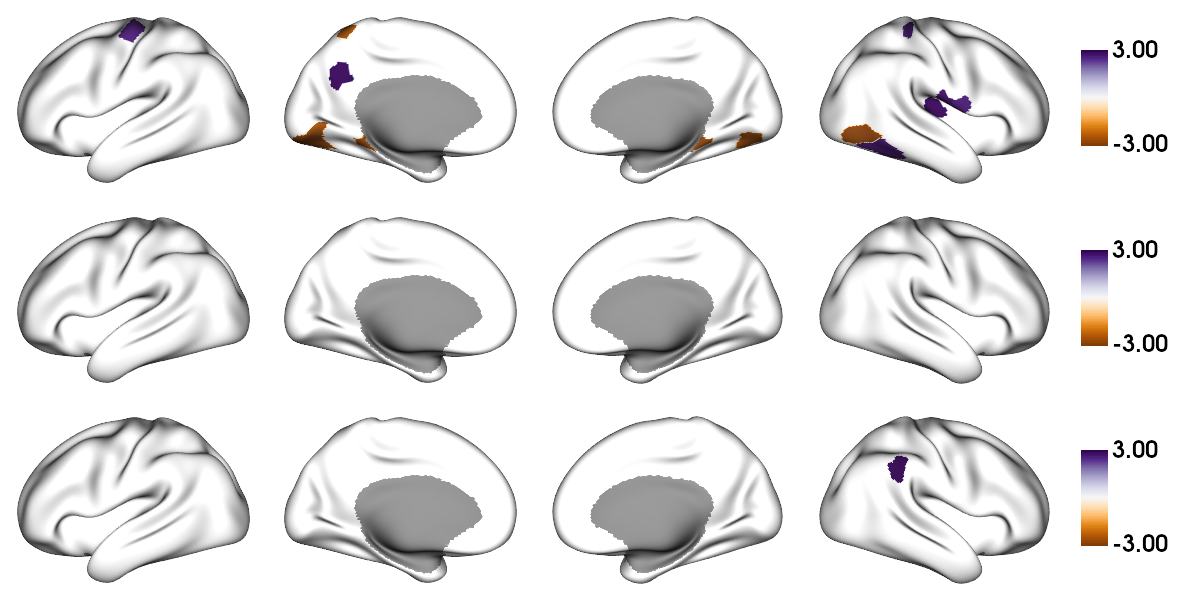

In [81]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]) > 0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_2groups_t.png')

In [82]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs BD+SCZ')

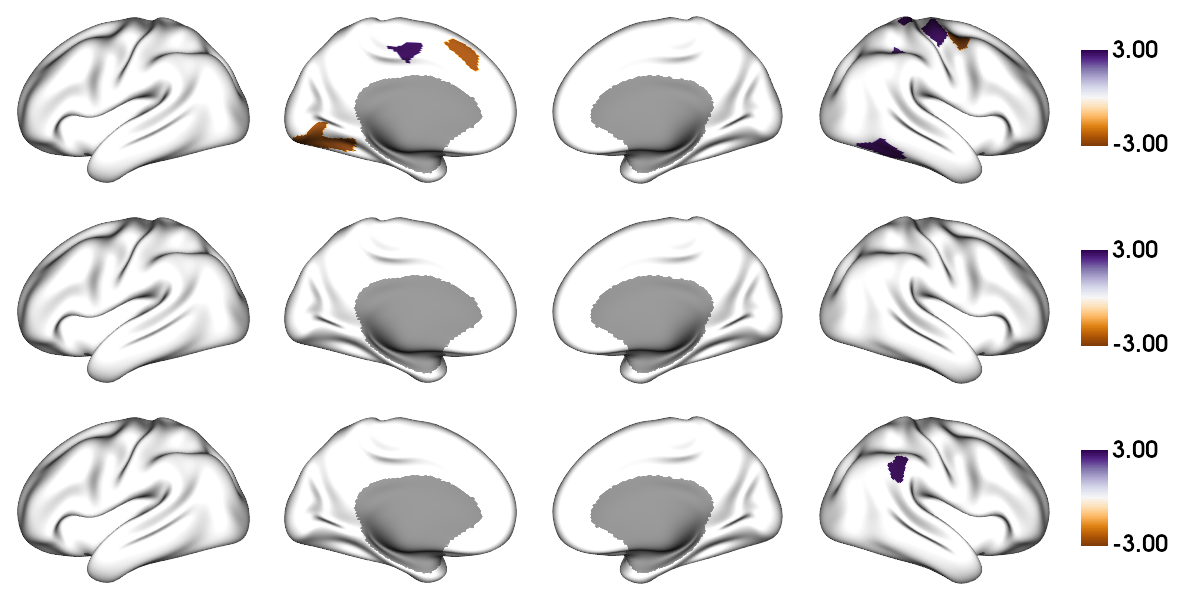

In [83]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_3groups_SCZ_t.png')

In [84]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs SCZ')

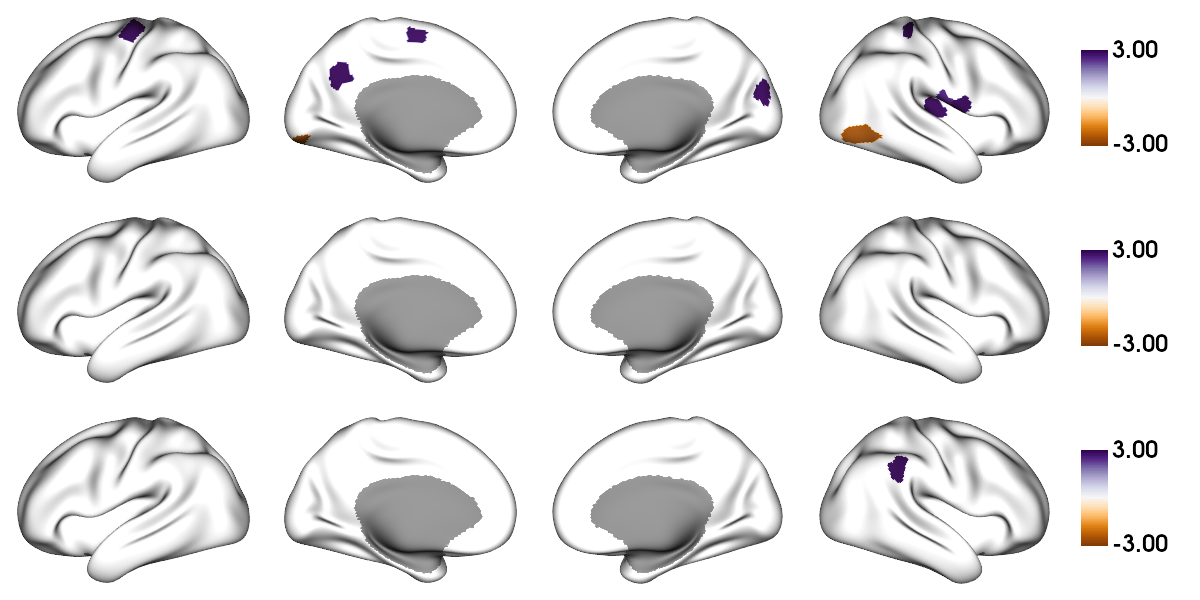

In [85]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='PuOr', color_range=(-3,3),
                display=True, filename='./new_figures/'+g_name+'_aligned_3groups_BD_t.png')

In [86]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD")

In [87]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("hamilton_21")

In [88]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS Positive Symptoms'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("SAPS Positive Symptoms")

In [89]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS disorganization'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("SAPS disorganization")

In [90]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("Amotivation")

In [91]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("DimEx")

In [92]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global blunted affect'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global blunted affect")

In [93]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global alogia'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global alogia")

In [94]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global anhedonia'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global anhedonia")

In [95]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['global avolition'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts['pvalue_fdr'] = fs.fdr(tmp[:,1])
sts.style.set_caption("global avolition")